In [ ]:
#Football Prediction - Data Exploration
#This notebook explores the collected match data

##Football Match Outcome Prediction - Data Exploration
#This notebook explores our collected match data from:
# - Premier League (698 matches)
# - Primeira Liga (387 matches)
# - Total: 1,085 matches (2020-2024)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import sys
from dotenv import load_dotenv

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load environment variables
load_dotenv()

# Add parent directory to path
sys.path.append('..')

# Import our database manager
from database_manager import FootballDatabaseManager

print("✓ Imports successful")

✓ Imports successful


In [3]:
# %% Cell 2: Connect to Database
db = FootballDatabaseManager(
    host=os.getenv('DB_HOST'),
    port=int(os.getenv('DB_PORT')),
    database=os.getenv('DB_NAME'),
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD')
)

print("✓ Connected to database")

✓ Connected to PostgreSQL database: football_predictions
✓ Connected to database


In [4]:
# %% Cell 3: Load Match Data
with db.get_cursor() as cursor:
    cursor.execute("""
        SELECT 
            m.match_id,
            m.fixture_date,
            m.league_id,
            l.league_name,
            m.season,
            m.home_team_id,
            m.away_team_id,
            ht.team_name as home_team,
            at.team_name as away_team,
            m.home_goals,
            m.away_goals,
            m.outcome,
            m.outcome_numeric
        FROM matches m
        JOIN teams ht ON m.home_team_id = ht.team_id
        JOIN teams at ON m.away_team_id = at.team_id
        JOIN leagues l ON m.league_id = l.league_id
        ORDER BY m.fixture_date
    """)
    
    matches_df = pd.DataFrame(cursor.fetchall())

# Convert date column
matches_df['fixture_date'] = pd.to_datetime(matches_df['fixture_date'])

print(f"✓ Loaded {len(matches_df)} matches")
print(f"Date range: {matches_df['fixture_date'].min()} to {matches_df['fixture_date'].max()}")

# Display first few rows
matches_df.head()

✓ Loaded 1085 matches
Date range: 2021-01-10 00:00:00 to 2024-12-05 00:00:00


,match_id,fixture_date,league_id,league_name,season,home_team_id,away_team_id,home_team,away_team,home_goals,away_goals,outcome,outcome_numeric
0,94202101108,2021-01-10,94,Primeira Liga,2020,1008,1009,Maritimo,Moreirense,0,0,D,0
1,94202101105,2021-01-10,94,Primeira Liga,2020,1005,1007,Famalicao,Guimaraes,1,2,A,2
2,942021011114,2021-01-11,94,Primeira Liga,2020,1014,1011,Sp Braga,Portimonense,3,0,H,1
3,94202101119,2021-01-11,94,Primeira Liga,2020,1009,1010,Moreirense,Pacos Ferreira,1,1,D,0
4,942021021012,2021-02-10,94,Primeira Liga,2020,1012,1010,Porto,Pacos Ferreira,2,1,H,1


In [5]:
# %% Cell 4: Basic Statistics
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"\nTotal Matches: {len(matches_df)}")
print(f"Leagues: {matches_df['league_name'].unique()}")
print(f"Seasons: {sorted(matches_df['season'].unique())}")
print(f"Teams: {len(set(matches_df['home_team'].unique()) | set(matches_df['away_team'].unique()))}")
print(f"Date Range: {matches_df['fixture_date'].min().date()} to {matches_df['fixture_date'].max().date()}")

# Check for missing values
print("\n" + "="*60)
print("MISSING VALUES")
print("="*60)
print(matches_df.isnull().sum())

DATASET OVERVIEW

Total Matches: 1085
Leagues: ['Primeira Liga' 'Premier League']
Seasons: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Teams: 20
Date Range: 2021-01-10 to 2024-12-05

MISSING VALUES
match_id           0
fixture_date       0
league_id          0
league_name        0
season             0
home_team_id       0
away_team_id       0
home_team          0
away_team          0
home_goals         0
away_goals         0
outcome            0
outcome_numeric    0
dtype: int64


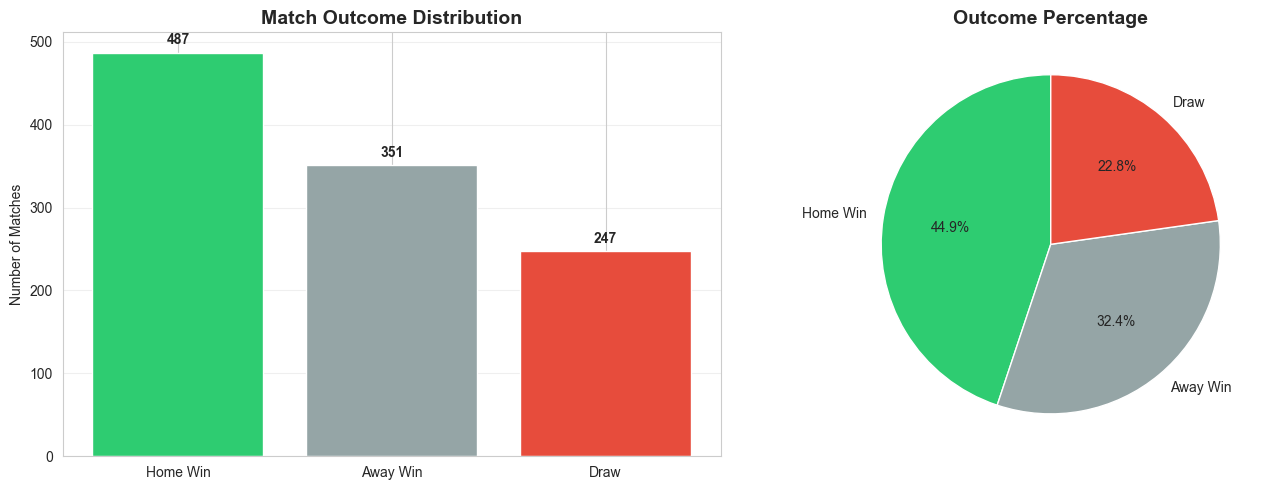


Outcome Distribution:
  Home Win       :  487 (44.88%)
  Away Win       :  351 (32.35%)
  Draw           :  247 (22.76%)


In [6]:
# %% Cell 5: Outcome Distribution
outcome_counts = matches_df['outcome'].value_counts()
outcome_pct = matches_df['outcome'].value_counts(normalize=True) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
outcome_labels = {'H': 'Home Win', 'D': 'Draw', 'A': 'Away Win'}
colors = ['#2ecc71', '#95a5a6', '#e74c3c']

ax1.bar([outcome_labels[x] for x in outcome_counts.index], 
        outcome_counts.values, 
        color=colors)
ax1.set_title('Match Outcome Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Matches')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(outcome_counts.values):
    ax1.text(i, v + 10, str(v), ha='center', fontweight='bold')

# Percentage pie chart
ax2.pie(outcome_pct.values, 
        labels=[outcome_labels[x] for x in outcome_pct.index],
        autopct='%1.1f%%',
        colors=colors,
        startangle=90)
ax2.set_title('Outcome Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nOutcome Distribution:")
for outcome, count in outcome_counts.items():
    pct = (count / len(matches_df)) * 100
    print(f"  {outcome_labels[outcome]:<15}: {count:>4} ({pct:>5.2f}%)")

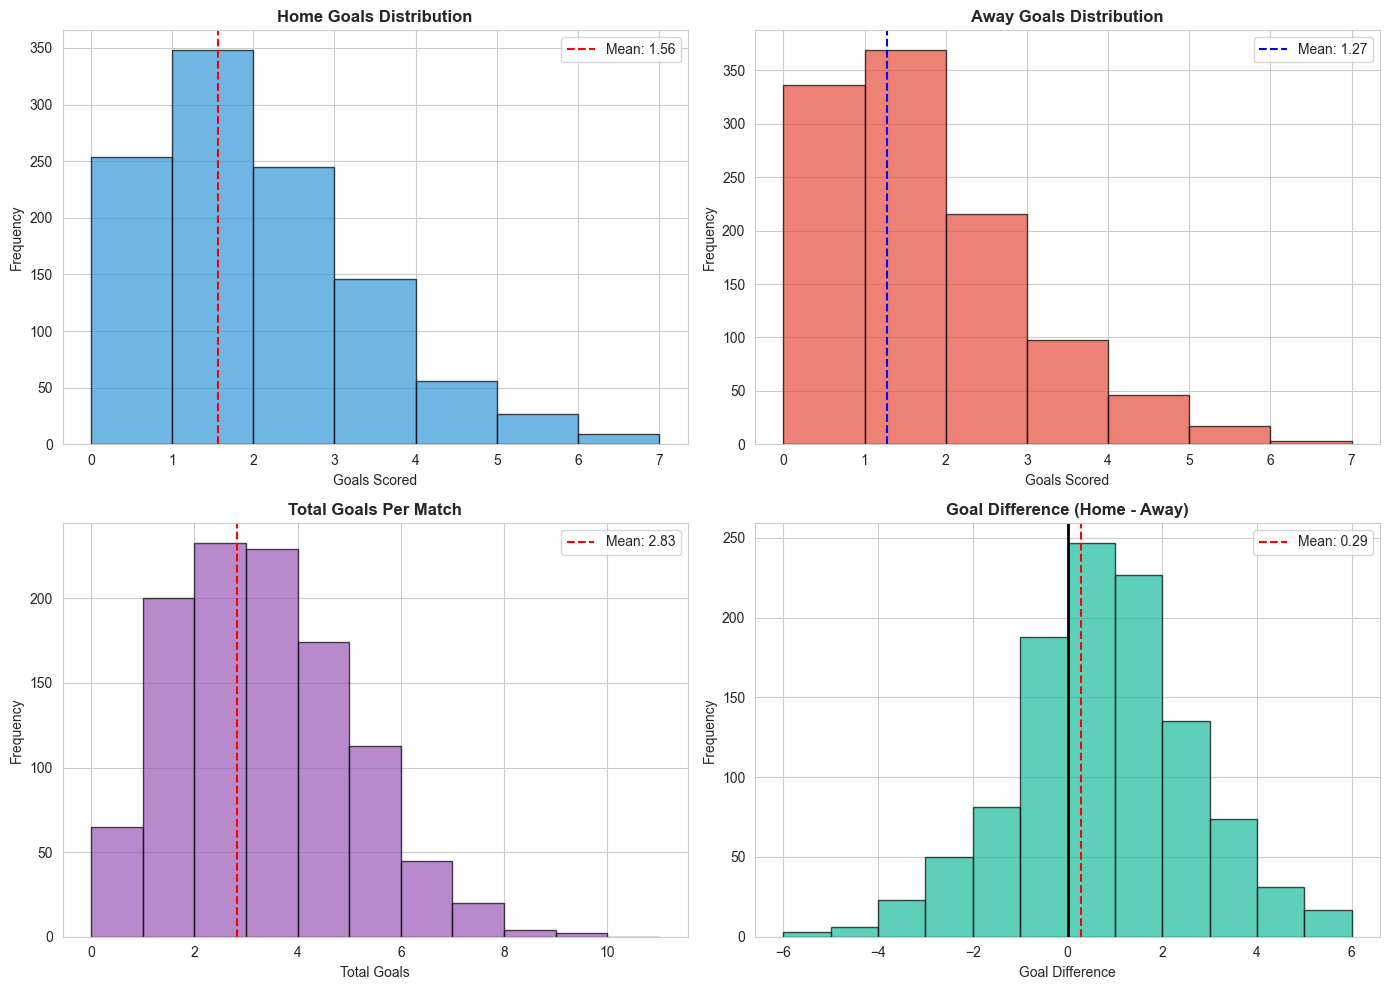


Goals Statistics:
  Average Home Goals: 1.56
  Average Away Goals: 1.27
  Average Total Goals: 2.83
  Average Goal Difference: 0.29


In [7]:
# %% Cell 6: Goals Distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Home goals distribution
axes[0, 0].hist(matches_df['home_goals'], bins=range(0, 8), 
                color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Home Goals Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Goals Scored')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(matches_df['home_goals'].mean(), 
                   color='red', linestyle='--', 
                   label=f'Mean: {matches_df["home_goals"].mean():.2f}')
axes[0, 0].legend()

# Away goals distribution
axes[0, 1].hist(matches_df['away_goals'], bins=range(0, 8), 
                color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Away Goals Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Goals Scored')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(matches_df['away_goals'].mean(), 
                   color='blue', linestyle='--', 
                   label=f'Mean: {matches_df["away_goals"].mean():.2f}')
axes[0, 1].legend()

# Total goals per match
matches_df['total_goals'] = matches_df['home_goals'] + matches_df['away_goals']
axes[1, 0].hist(matches_df['total_goals'], bins=range(0, 12), 
                color='#9b59b6', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Total Goals Per Match', fontweight='bold')
axes[1, 0].set_xlabel('Total Goals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(matches_df['total_goals'].mean(), 
                   color='red', linestyle='--', 
                   label=f'Mean: {matches_df["total_goals"].mean():.2f}')
axes[1, 0].legend()

# Goal difference
matches_df['goal_diff'] = matches_df['home_goals'] - matches_df['away_goals']
axes[1, 1].hist(matches_df['goal_diff'], bins=range(-6, 7), 
                color='#1abc9c', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Goal Difference (Home - Away)', fontweight='bold')
axes[1, 1].set_xlabel('Goal Difference')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(0, color='black', linestyle='-', linewidth=2)
axes[1, 1].axvline(matches_df['goal_diff'].mean(), 
                   color='red', linestyle='--', 
                   label=f'Mean: {matches_df["goal_diff"].mean():.2f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\nGoals Statistics:")
print(f"  Average Home Goals: {matches_df['home_goals'].mean():.2f}")
print(f"  Average Away Goals: {matches_df['away_goals'].mean():.2f}")
print(f"  Average Total Goals: {matches_df['total_goals'].mean():.2f}")
print(f"  Average Goal Difference: {matches_df['goal_diff'].mean():.2f}")

In [8]:
# %% Cell 7: Home Advantage Analysis
home_win_rate = (matches_df['outcome'] == 'H').sum() / len(matches_df) * 100
draw_rate = (matches_df['outcome'] == 'D').sum() / len(matches_df) * 100
away_win_rate = (matches_df['outcome'] == 'A').sum() / len(matches_df) * 100

print("="*60)
print("HOME ADVANTAGE ANALYSIS")
print("="*60)
print(f"Home Win Rate: {home_win_rate:.2f}%")
print(f"Draw Rate: {draw_rate:.2f}%")
print(f"Away Win Rate: {away_win_rate:.2f}%")
print(f"\nHome Advantage: {home_win_rate - away_win_rate:.2f} percentage points")

HOME ADVANTAGE ANALYSIS
Home Win Rate: 44.88%
Draw Rate: 22.76%
Away Win Rate: 32.35%

Home Advantage: 12.53 percentage points


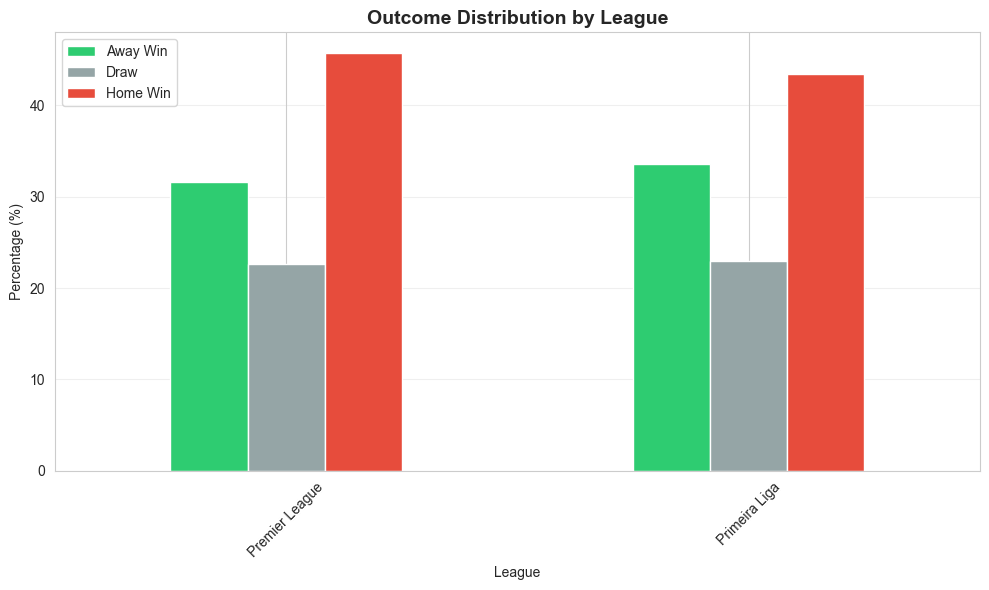


Outcome by League:
outcome             A      D      H
league_name                        
Premier League  31.66  22.64  45.70
Primeira Liga   33.59  23.00  43.41


In [9]:
# %% Cell 8: League Comparison
league_outcomes = pd.crosstab(matches_df['league_name'], matches_df['outcome'], normalize='index') * 100

league_outcomes.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Outcome Distribution by League', fontsize=14, fontweight='bold')
plt.xlabel('League')
plt.ylabel('Percentage (%)')
plt.legend(['Away Win', 'Draw', 'Home Win'])
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nOutcome by League:")
print(league_outcomes.round(2))

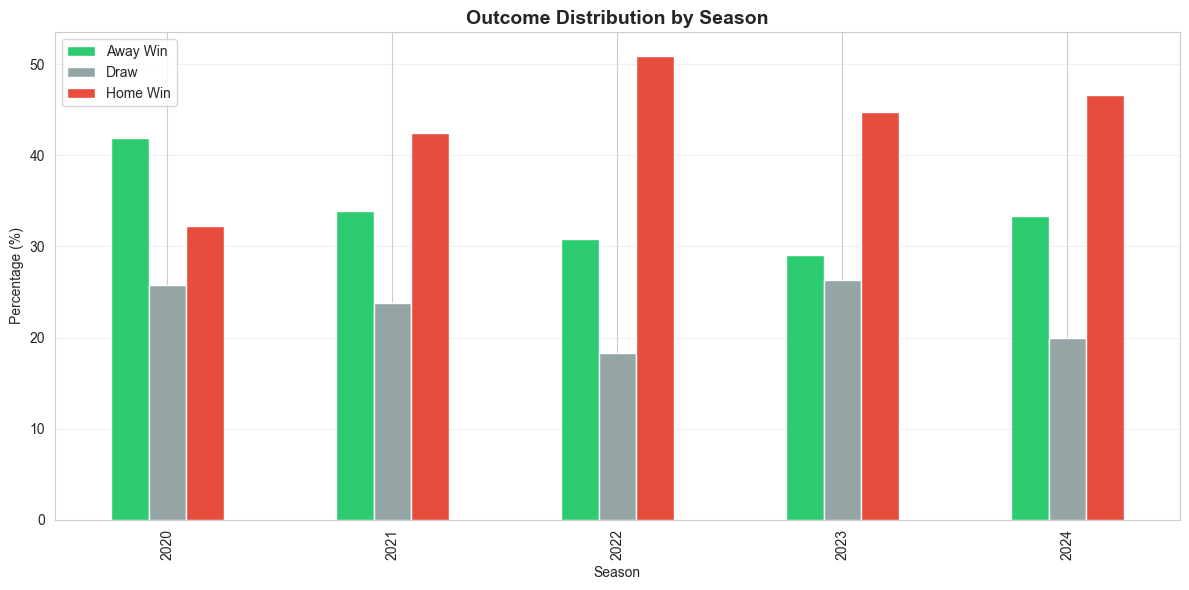


Outcome by Season:
outcome      A      D      H
season                      
2020     41.94  25.81  32.26
2021     33.85  23.74  42.41
2022     30.80  18.25  50.95
2023     29.03  26.27  44.70
2024     33.33  20.00  46.67


In [10]:
# %% Cell 9: Seasonal Trends
season_outcomes = pd.crosstab(matches_df['season'], matches_df['outcome'], normalize='index') * 100

season_outcomes.plot(kind='bar', figsize=(12, 6), color=colors)
plt.title('Outcome Distribution by Season', fontsize=14, fontweight='bold')
plt.xlabel('Season')
plt.ylabel('Percentage (%)')
plt.legend(['Away Win', 'Draw', 'Home Win'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nOutcome by Season:")
print(season_outcomes.round(2))

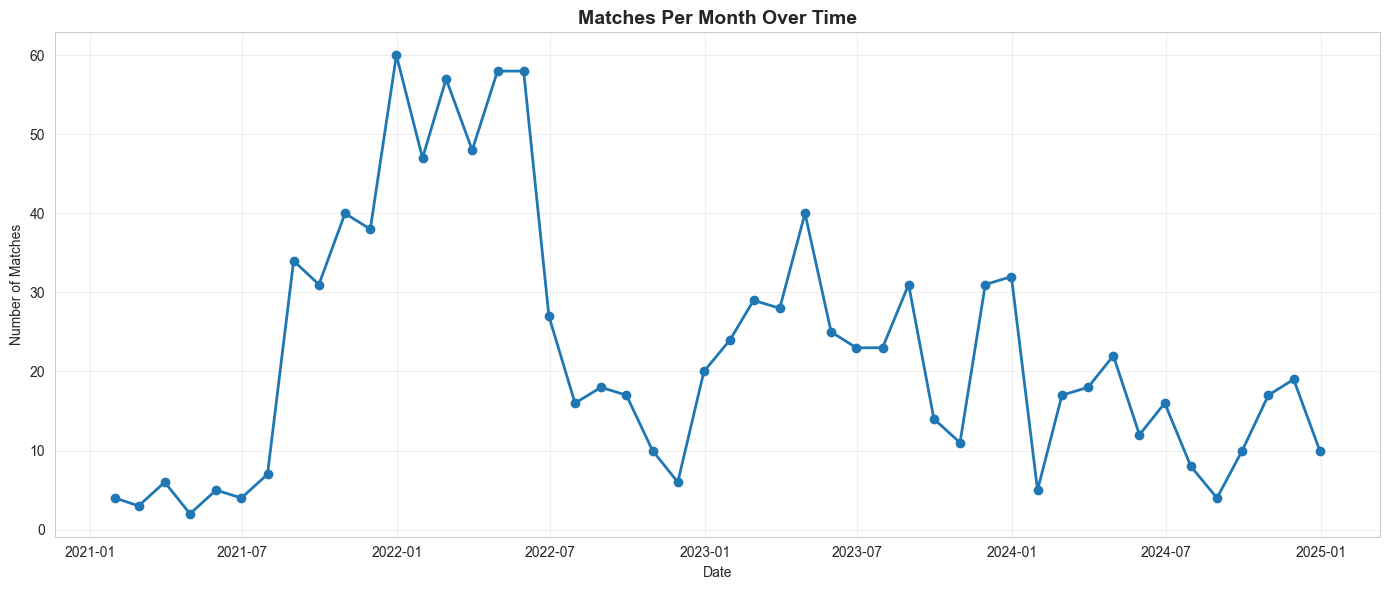

In [13]:
# %% Cell 10: Time Series - Matches Over Time
matches_per_month = matches_df.set_index('fixture_date').resample('ME').size()

plt.figure(figsize=(14, 6))
plt.plot(matches_per_month.index, matches_per_month.values, marker='o', linewidth=2)
plt.title('Matches Per Month Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Matches')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

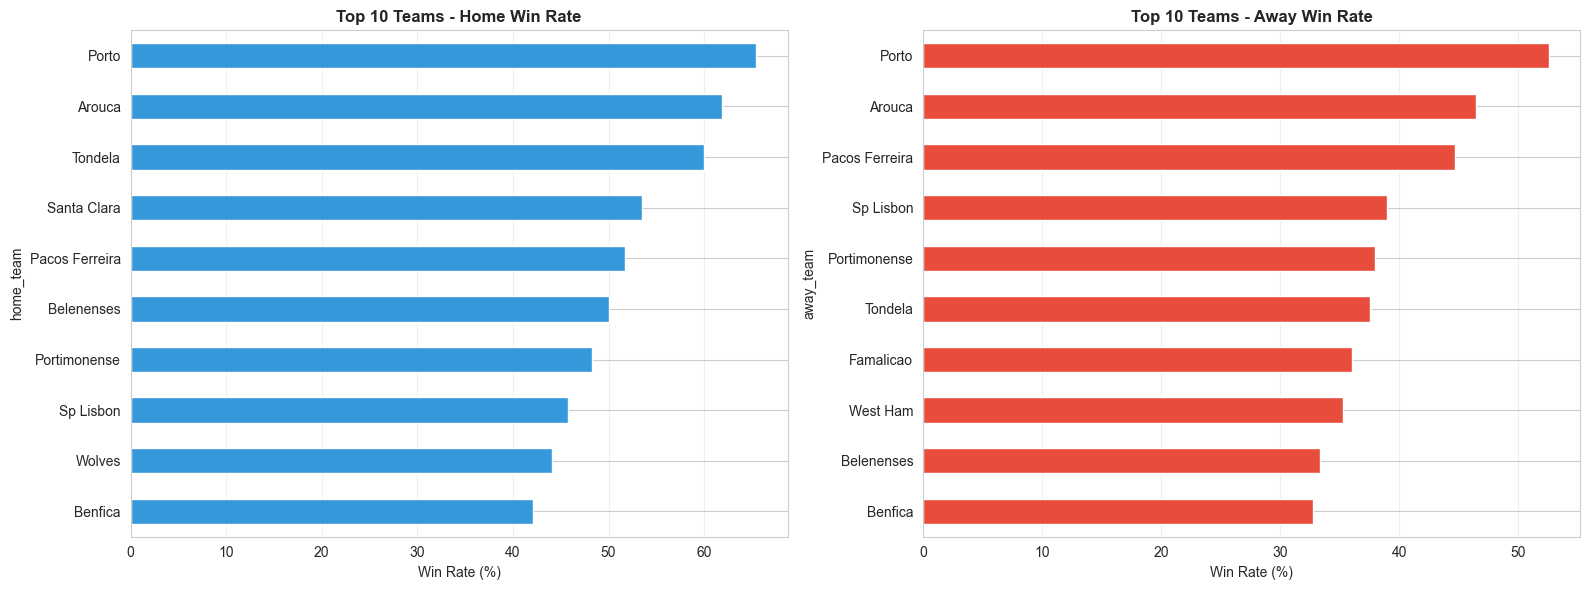

In [16]:
# %% Cell 11: Top Performing Teams
# Home performance
home_wins = matches_df[matches_df['outcome'] == 'H'].groupby('home_team').size()
home_matches = matches_df.groupby('home_team').size()
top_home_win_rates = (home_wins / home_matches * 100).sort_values(ascending=False).head(10)  # Changed variable name

# Away performance
away_wins = matches_df[matches_df['outcome'] == 'A'].groupby('away_team').size()
away_matches = matches_df.groupby('away_team').size()
top_away_win_rates = (away_wins / away_matches * 100).sort_values(ascending=False).head(10)  # Changed variable name

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top home teams
top_home_win_rates.plot(kind='barh', ax=ax1, color='#3498db')  # Updated variable name
ax1.set_title('Top 10 Teams - Home Win Rate', fontweight='bold')
ax1.set_xlabel('Win Rate (%)')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Top away teams
top_away_win_rates.plot(kind='barh', ax=ax2, color='#e74c3c')  # Updated variable name
ax2.set_title('Top 10 Teams - Away Win Rate', fontweight='bold')
ax2.set_xlabel('Win Rate (%)')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Recalculate overall rates (in case they were overwritten)
home_win_rate = (matches_df['outcome'] == 'H').sum() / len(matches_df) * 100
draw_rate = (matches_df['outcome'] == 'D').sum() / len(matches_df) * 100
away_win_rate = (matches_df['outcome'] == 'A').sum() / len(matches_df) * 100

In [19]:
# %% Cell 12: Summary Statistics
print("="*60)
print("KEY INSIGHTS")
print("="*60)
print(f"\n1. HOME ADVANTAGE:")
print(f"   - Home teams win {home_win_rate:.1f}% of matches")
print(f"   - {home_win_rate - away_win_rate:.1f} percentage point advantage over away teams")

print(f"\n2. SCORING:")
print(f"   - Average goals per match: {matches_df['total_goals'].mean():.2f}")
print(f"   - Home teams score {matches_df['home_goals'].mean():.2f} goals on average")
print(f"   - Away teams score {matches_df['away_goals'].mean():.2f} goals on average")

print(f"\n3. PREDICTABILITY:")
high_scoring = (matches_df['total_goals'] >= 3).sum() / len(matches_df) * 100
low_scoring = (matches_df['total_goals'] <= 1).sum() / len(matches_df) * 100
print(f"   - High-scoring matches (3+ goals): {high_scoring:.1f}%")
print(f"   - Low-scoring matches (0-1 goals): {low_scoring:.1f}%")
print(f"   - Draw rate: {draw_rate:.1f}%")

KEY INSIGHTS

1. HOME ADVANTAGE:
   - Home teams win 44.9% of matches
   - 12.5 percentage point advantage over away teams

2. SCORING:
   - Average goals per match: 2.83
   - Home teams score 1.56 goals on average
   - Away teams score 1.27 goals on average

3. PREDICTABILITY:
   - High-scoring matches (3+ goals): 54.1%
   - Low-scoring matches (0-1 goals): 24.4%
   - Draw rate: 22.8%


In [20]:
# %% Cell 13: Close Database Connection
db.close()
print("\n✓ Analysis complete!")

✓ Database connections closed

✓ Analysis complete!
